In [1]:
import numpy as np
import matplotlib.pyplot as plt
from reinforced_concrete.sections import create_concrete_material, create_steel_material, Bars, ReinforcedConcreteSection

plt.style.use(["science", "retro"])
#plt.style.use(["science", "notebook","std-colors"]) # faster but witout LaTeX render

import pandas as pd

In [2]:
cls  = create_concrete_material("EC2","C25/30") 
steel  = create_steel_material("NTC18","B450C")

print(cls)
print(steel)

ConcreteMaterial(name='C25/30', fck=25, rck=30, fcm=33, fcd=14.167, Ecm=31475.81, fctm=2.565, fctk=1.795, fctd=1.197, ec2=0.002, ecu2=0.0035, ec3=0.00175, ecu3=0.0035)
SteelMaterial(name='B450C', fyk=450, Es=210000, esu=0.01)


In [3]:
As = Bars(n_bars=6, diameter=20, steel_material=steel)
As1 = Bars(n_bars=3, diameter=12, steel_material=steel)
section_1 = ReinforcedConcreteSection(b=300, d=410, d1=40, d2=40, concrete_material=cls, As=As, As1=As1, name="sec1")

In [4]:
section_1

ReinforcedConcreteSection(b=300, d=410, d1=40, d2=40, concrete_material=ConcreteMaterial(name='C25/30', fck=25, rck=30, fcm=33, fcd=14.167, Ecm=31475.81, fctm=2.565, fctk=1.795, fctd=1.197, ec2=0.002, ecu2=0.0035, ec3=0.00175, ecu3=0.0035), As=Bars(n_bars=6, diameter=20, steel_material=SteelMaterial(name='B450C', fyk=450, Es=210000, esu=0.01)), As1=Bars(n_bars=3, diameter=12, steel_material=SteelMaterial(name='B450C', fyk=450, Es=210000, esu=0.01)), name='sec1')

In [5]:
b = section_1.b
As = section_1.As.area()
As1 = section_1.As1.area()
d = section_1.d
d1 = section_1.d1
d2 = section_1.d2
h = section_1.h #TODO TOGLIERE LA H DALLE FORMULE E METTERLA COME D+D1

fck = section_1.concrete_material.fck
Ec = section_1.concrete_material.Ecm
ec2 = section_1.concrete_material.ec2
ecu = section_1.concrete_material.ecu2

fyk = section_1.As.steel_material.fyk
Es = section_1.As.steel_material.Es
ese = section_1.As.steel_material.ese
esu = section_1.As.steel_material.esu

fyk1 = section_1.As1.steel_material.fyk
ese1 = section_1.As1.steel_material.ese
esu1 = section_1.As1.steel_material.esu

In [6]:
b = 400
# h = 450
# As = 1407
# As1 = 1206
# d = 410
# d1 = 40
# d2 = 40
# 
# fck = 25
# fyk = 450
# fyk1 = 450
# Ec = 31475.806
# Es = 200000
# 
# ese = 1.9565/1000
# ese1 = 1.9565/1000
# esu = 10/1000 # campo 1 e 2
# ecu = 3.5/1000
# ec2 = 2/1000

In [7]:
xi23 = ecu/(ecu + esu)
xi23

0.25925925925925924

In [8]:
xi34 = ecu/(ecu + ese1)
xi34

0.6525767226404169

In [9]:
xi1a1b = (esu * d2 - ese1 * d)/(d*(esu - ese1) )
xi1a1b

-0.10910444982312421

In [10]:
xi12 = 0

In [11]:
xi2a2b = (d2/d * esu + abs(ese1)) / (esu + abs(ese1) )
xi3a3b = ecu/(ecu-abs(ese1)) * d2/d

print(f"{xi2a2b = }") 
print(f"{xi3a3b = }") 

if xi2a2b > xi23: 
    print(f"Non snerva in 2, xi23 = {xi23}")
else:
    print(f"Snerva in 2, xi23 = {xi23}")

if xi3a3b > xi34: 
    print(f"Non snerva in 3, xi34 = {xi34}")
else:
    print(f"Snerva in 3, xi34 = {xi34}")

xi2a2b = 0.2393053249904227
xi3a3b = 0.20863609015596798
Snerva in 2, xi23 = 0.25925925925925924
Snerva in 3, xi34 = 0.6525767226404169


In [12]:
def storeToDict(dic,strainRange,N,M,nu,mu):
    dic[strainRange]["N"] = N
    dic[strainRange]["M"] = M
    dic[strainRange]["nu"] = nu
    dic[strainRange]["mu"] = mu

In [13]:
# Strain Range 2
def psi_2(xi):
    if xi < 1/6:
        return xi/(1-xi) * esu/(3 * ec2**2) * (3 * ec2 - xi/(1-xi) * esu)
    else:
        return 1 - ( ec2*(1-xi) ) / ( 3*esu*xi )

def lamb_2(xi):
# only for n = 2 C<C50/60
    if xi == 0: #TODO perché si faceva ?
        return 0
    elif xi <= 1/6:
        return (4*ec2 - esu*xi/(1-xi)) / (4*(3*ec2 - esu*xi/(1-xi))) 
    else:
        return ( (6*esu**2 + 4*esu*ec2 +  ec2**2)*xi**2 - 2*ec2**2 * xi + ec2**2 - 4*esu*ec2*xi ) / ( 4*esu*xi*((3*esu+ec2)*xi - ec2 ))        

In [14]:
def psi_6(xi):
    return (xi**2 - 6/7*xi+125/1029)/(xi - 3/7)**2

def lamb_6(xi, t):
    return 3/14 * ((2401*xi**2 - 2058*xi + 185)/(1029*xi**2 - 882*xi + 125))
    #return (1/2 + 1/3 * ec2/ecu * ((1-t/h)/(xi-t/h))**2 * (-1 + 1/4*ec2/ecu))/(1/(3*ecu) * (3*ecu - ec2*((1-t/h)/(xi-t/h))**2))

In [15]:
def strainDistribution(As,As1) -> dict[dict]:
    """
    Return a dictionary with dictionaries for stain ranges (1-6), each with numpy arrays of M, N, mu and nu values
    
    Example: 
    As = 1407
    As1 = 1206
    MN_up = strainDistribution(As,As1)
    MN_up["2"]["M"] is an array with M values for strain range 2
    """
    dic = {}
    fcd = fck * 0.85 / 1.5
    fyd = fyk/1.15 

    # ---------------------------------------------------------------------
    # ------------------------------ CAMPO 1 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "1"
    dic[strainRange]={}
    xi = np.linspace(-50/d,0,20)
    x = xi * d
    es1 =  (esu * (d2 - x)) /(d - x) #TODO tanto vale mettere la formula con xi (ovunque)

    fyd1 = []
    for i in range(len(es1)):
        if abs(es1[i]) > ese1:
            fyd1.append(fyk1/1.15)
        else:
            fyd1.append(Es * es1[i])
    fyd1 = np.array(fyd1)        

    N =  - fyd1*As1 - fyd * As 
    M =  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)  
    storeToDict(dic,strainRange,N,M,nu,mu)
    # ---------------------------------------------------------------------
    # ------------------------------ CAMPO 2 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "2"
    dic[strainRange]={}

    xi = np.linspace(0,xi23,130)
    x = xi * d
    es1 = - (esu * (x - d2)) /(d - x) #TODO tanto vale mettere la formula con xi (ovunque)

    fyd1 = []
    for i in range(len(es1)):
        if abs(es1[i]) > ese1 and es1[i] > 0:
            fyd1.append(fyk1/1.15)
        elif abs(es1[i]) > ese1 and es1[i] < 0:
            fyd1.append(-fyk1/1.15)
        else:
            fyd1.append(Es * es1[i])
    fyd1 = np.array(fyd1)        

    psi = np.array([psi_2(xi_i) for xi_i in xi])
    lamb = np.array([lamb_2(xi_i) for xi_i in xi])

    N = b * psi * x * fcd  - fyd1*As1 - fyd * As 
    M = b * psi * x * fcd * (h/2 - lamb*x)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)
    
    storeToDict(dic,strainRange,N,M,nu,mu)
    
    # ---------------------------------------------------------------------
    # ------------------------------ CAMPO 3 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "3"
    dic[strainRange]={}
    
    fyd = fyk/1.15

    xi = np.linspace(xi23,xi34,100)
    x = xi * d

    es1 = - ecu * (x - d2) / x

   # fyd1 = -fyk1/1.15  
    fyd1 = []
    for i in range(len(es1)):
        if abs(es1[i]) > ese1 and es1[i] > 0:
            fyd1.append(fyk1/1.15)
        elif abs(es1[i]) > ese1 and es1[i] < 0:
            fyd1.append(-fyk1/1.15)
        else:
            fyd1.append(Es * es1[i])
    fyd1 = np.array(fyd1)

    psi = 17/21 # 0.8095238095238095
    lamb = 99/238 # 0.4159663865546219

    # solo campo 3B. Da capire il 3A perché non lo considera!
    
    N = b * psi * x * fcd  - fyd1*As1 - fyd * As  
    M = b * psi * x * fcd * (h/2 - lamb*x)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)
    
    storeToDict(dic,strainRange,N,M,nu,mu)
    
    # ---------------------------------------------------------------------
    # ------------------------------ CAMPO 4 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "4"
    dic[strainRange]={}

    xi = np.linspace(xi34,1,100)
    x = xi * d

    es1 = - ecu * (x - d2) / x
    es = ecu * (d-x) / x

    fyd1 = -fyk1/1.15  
    fyd = Es*es

    psi = 17/21 # 0.8095238095238095
    lamb = 99/238 # 0.4159663865546219
    
    N = b * psi * x * fcd  - fyd1*As1 - fyd * As  
    M = b * psi * x * fcd * (h/2 - lamb*x)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)
    
    storeToDict(dic,strainRange,N,M,nu,mu)
    
    # ---------------------------------------------------------------------
    # ------------------------------ CAMPO 5 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "5"
    dic[strainRange]={}

    xi = np.linspace(1,1+d1/d,50)
    x = xi * d

    es1 = - ecu * (x - d2) / x
    es = - ecu * (d-x) / x

    fyd1 = -fyk1/1.15  
    fyd = - Es*es
    psi = 17/21 # 0.8095238095238095
    lamb = 99/238 # 0.4159663865546219
    
    N = b * psi * x * fcd  - fyd1*As1 - fyd * As  
    M = b * psi * x * fcd * (h/2 - lamb*x)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)
    
    storeToDict(dic,strainRange,N,M,nu,mu)
    

    # ---------------------------------------------------------------------
    # ------------------------------ CAMPO 6 ------------------------------
    # ---------------------------------------------------------------------
    
    strainRange = "6"
    dic[strainRange]={}

    xi = np.linspace(1+d1/d,50,200)
    x = xi * d
    
    t = (ecu-ec2)*(d+d1)/ecu # C<C50/60: 3/7 * h

    es1 = - ec2 * (x - d2) / (x-t)
    es = - ec2 * (x-d) / (x-t)

    fyd1 = -fyk1/1.15  

    #x6a6b = (ec2 * d + ese * t)/(ec2 + ese)

    fyd = []
    for i in range(len(x)):
        if abs(es[i]) < ese:
            fyd.append(Es * es[i])
        else:
            fyd.append(- fyk/1.15)
    fyd = np.array(fyd)

    psi = np.array([psi_6(xi_i) for xi_i in xi])
    lamb = np.array([lamb_6(xi_i,t) for xi_i in xi])
    psi[0] = 17/21 # 0.8095238095238095
    lamb[0] = 99/238 # 0.4159663865546219

    N = b * psi * h * fcd  - fyd1*As1 - fyd * As  
    M = b * psi * h * fcd * (h/2 - lamb*h)  - fyd1*As1* (h/2 - d2) + fyd * As* (h/2 - d1)
    nu = N/(b*d*fcd)
    mu = M/(b*d**2*fcd)

    storeToDict(dic,strainRange,N,M,nu,mu)
    
    return dic

In [16]:
# Above and below x axis: invert steel areas and change M sign in plotting function 
MN_up = strainDistribution(As,As1)
MN_down = strainDistribution(As1,As) 

In [17]:
def create_multiple_strainDistribution(As: list, As1: list) -> list[tuple[dict]]:
    """example [(MN_up_1, MN_down_1), (MN_up_2, MN_down_2), ...]"""
    multiple_strain_distributions = []
    for i in range(len(As1)):
        # tup: (mn_up, mn_down)
        tup = strainDistribution(As[i], As1[i]), strainDistribution(As1[i], As[i])
        multiple_strain_distributions.append(tup)
    return multiple_strain_distributions

def a(n_bars: int , diameter: int, string = False):
    if string == False:
        return n_bars * 3.14 * diameter**2 / 4
    else:
        "Return a string like:'2Ø4' "
        return f"{n_bars}Ø{diameter}"


As_list = [a(4,12),a(4,14), a(4,16)]
As1_list = [a(2,12),a(2,14), a(2,16)]

mult = create_multiple_strainDistribution(As_list,As1_list)

In [18]:
# As_list = [Bars(4,12,steel_material=steel), Bars(4,14,steel_material=steel), Bars(4,16,steel_material=steel)]
# As_list_area = [bar.area for bar in As_list]
# As_list_area #TODO

In [19]:
COLORS = [list(plt.rcParams['axes.prop_cycle'])[col]['color'] for col in range(len(list(plt.rcParams['axes.prop_cycle'])))] #colors from the matplotlib style

def interaction_diagram_single(dic_up,dic_down, NM=True,):
    x = "N" if NM else "nu"
    y = "M" if NM else "mu"

    fig, ax = plt.subplots(1,1, figsize = (12, 7))
    for i in range(1,7): 
        ax.plot(dic_up[f"{i}"][x],dic_up[f"{i}"][y],color=COLORS[i-1],label=f" Campo {i}")
        ax.plot(dic_down[f"{i}"][x],-dic_down[f"{i}"][y],color=COLORS[i-1])
        ax.set_xlabel(x) # "r"$\bf" + x + r"}$""
        ax.set_ylabel(y)
        ax.grid("True",which="both",linestyle='dashed')
        ax.set_title(f"{y} - {x} diagram", fontsize=14)
        ax.legend(loc = "upper right", frameon = "True")

    ax.text(
        x=0.5, 
        y=0.5, 
        s=f"b = {b}\nh = {h}\nAs   = {As} \nAs1 = {As1} ", 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes, #used to make x,y coords in global coordinates
        bbox=dict(facecolor='grey', alpha=0.3)
    )

    #plt.savefig(f"{x}_{y}_diagram.pdf")

    return fig, ax

def interaction_diagram_multiple(
        multiple_strainDistribution: create_multiple_strainDistribution, 
        NM=True,
        NM_values: list = None
    ):
    x = "N" if NM else "nu"
    y = "M" if NM else "mu"

    fig, ax = plt.subplots(1,1, figsize = (12, 7))
    ax.set_xlabel(x) # "r"$\bf" + x + r"}$""
    ax.set_ylabel(y)
    ax.grid("True",which="both",linestyle='dashed')
    ax.set_title(f"{y} - {x} diagram", fontsize=14)
    for area in range(len(multiple_strainDistribution)):
        for i in range(1,7): 
            dic_up, dic_down = multiple_strainDistribution[area]
            ax.plot(dic_up[f"{i}"][x],dic_up[f"{i}"][y],dic_down[f"{i}"][x],-dic_down[f"{i}"][y],color=COLORS[i-1])
        #ax.plot([],[], label=f"Area: {area}")    
        
    ax.text(
        x=0.5, 
        y=0.5, 
        s=f"b = {b}\nh = {h}\nAs   = {As_list} \nAs1 = {As1_list} ", 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes, #used to make x,y coords in global coordinates
        bbox=dict(facecolor='grey', alpha=0.3)
    )
    if NM_values:
        x_points = NM_values[0]
        y_points = NM_values[1]
        ax.plot(x_points, y_points,"rs")

    plt.savefig(f"{y}_{x}_diagram_multiple.pdf")
    
    return fig, ax


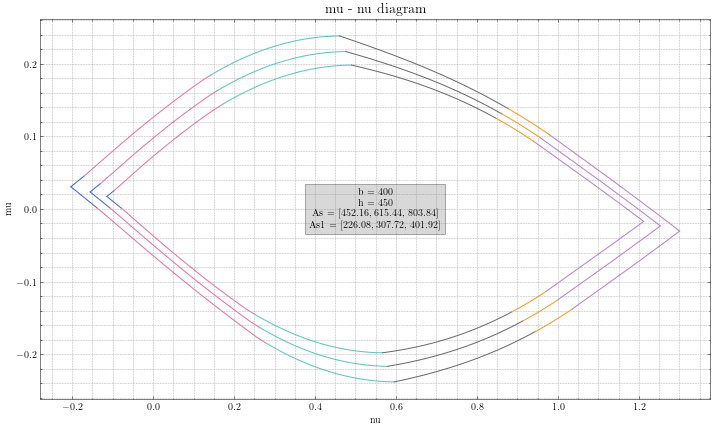

In [20]:
fig, ax = interaction_diagram_multiple(mult, NM = False) #, NM_values=[[10000,3454515],[2,6]])
plt.show()

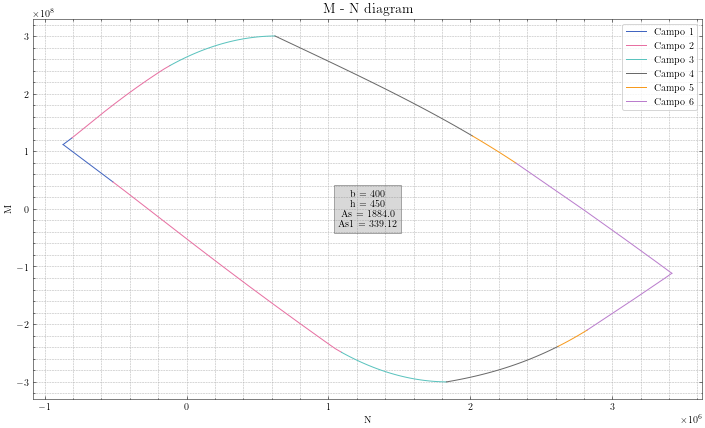

In [21]:
fig, ax = interaction_diagram_single(MN_up,MN_down, NM=True)
plt.show()

In [22]:
c1 = pd.DataFrame(MN_up["1"])
c1

,N,M,nu,mu
0,-869916.521739,1.118359e+08,-0.374426,0.117405
1,-869916.521739,1.118359e+08,-0.374426,0.117405
2,-869916.521739,1.118359e+08,-0.374426,0.117405
3,-866548.837172,1.124589e+08,-0.372977,0.118059
4,-863136.538845,1.130902e+08,-0.371508,0.118722
5,-859684.048548,1.137289e+08,-0.370022,0.119392
6,-856190.651968,1.143752e+08,-0.368518,0.120071
7,-852655.617764,1.150291e+08,-0.366997,0.120757
8,-849078.197060,1.156910e+08,-0.365457,0.121452
9,-845457.622909,1.163608e+08,-0.363899,0.122155


In [23]:
c2 = pd.DataFrame(MN_up["2"])
c2

,N,M,nu,mu
0,-806695.635207,1.235317e+08,-0.347215,0.129683
1,-805354.554972,1.237817e+08,-0.346638,0.129945
2,-803914.792292,1.240536e+08,-0.346018,0.130231
3,-802376.708837,1.243472e+08,-0.345356,0.130539
4,-800740.677008,1.246625e+08,-0.344652,0.130870
...,...,...,...,...
125,-136827.636567,2.462714e+08,-0.058893,0.258535
126,-131847.000462,2.469820e+08,-0.056749,0.259281
127,-126866.364356,2.476882e+08,-0.054605,0.260022
128,-121885.728251,2.483900e+08,-0.052462,0.260759


In [24]:
c3 = pd.DataFrame(MN_up["3"])
c3

,N,M,nu,mu
0,-116905.092145,2.490874e+08,-0.050318,0.261491
1,-109432.880147,2.501028e+08,-0.047102,0.262557
2,-101960.668148,2.511081e+08,-0.043886,0.263612
3,-94488.456149,2.521032e+08,-0.040669,0.264657
4,-87016.244150,2.530882e+08,-0.037453,0.265691
...,...,...,...,...
95,592955.047733,3.003393e+08,0.255217,0.315295
96,600427.259732,3.003928e+08,0.258434,0.315351
97,607899.471731,3.004361e+08,0.261650,0.315396
98,615371.683730,3.004693e+08,0.264866,0.315431


In [25]:
c4 = pd.DataFrame(MN_up["4"])
c4

,N,M,nu,mu
0,6.228439e+05,3.004924e+08,0.268082,0.315455
1,6.407943e+05,2.984046e+08,0.275808,0.313264
2,6.586240e+05,2.963312e+08,0.283482,0.311087
3,6.763347e+05,2.942720e+08,0.291105,0.308925
4,6.939285e+05,2.922264e+08,0.298678,0.306778
...,...,...,...,...
95,1.967377e+06,1.336147e+08,0.846791,0.140268
96,1.978958e+06,1.319546e+08,0.851775,0.138525
97,1.990504e+06,1.302931e+08,0.856745,0.136781
98,2.002016e+06,1.286301e+08,0.861700,0.135035


In [26]:
c5 = pd.DataFrame(MN_up["5"])
c5

,N,M,nu,mu
0,2.013493e+06,1.269657e+08,0.866640,0.133288
1,2.019989e+06,1.260206e+08,0.869436,0.132296
2,2.026475e+06,1.250750e+08,0.872227,0.131303
3,2.032949e+06,1.241289e+08,0.875014,0.130310
4,2.039413e+06,1.231823e+08,0.877796,0.129316
5,2.045866e+06,1.222350e+08,0.880574,0.128322
6,2.052308e+06,1.212873e+08,0.883346,0.127327
7,2.058740e+06,1.203389e+08,0.886115,0.126331
8,2.065161e+06,1.193899e+08,0.888879,0.125335
9,2.071572e+06,1.184403e+08,0.891638,0.124338


In [27]:
c6 = pd.DataFrame(MN_up["6"])
c6

,N,M,nu,mu
0,2.320073e+06,7.983928e+07,0.998597,0.083815
1,2.804346e+06,-2.558714e+06,1.207036,-0.002686
2,2.981586e+06,-3.360490e+07,1.283323,-0.035278
3,3.086624e+06,-5.212464e+07,1.328533,-0.054720
4,3.155589e+06,-6.434673e+07,1.358216,-0.067551
...,...,...,...,...
195,3.419849e+06,-1.118251e+08,1.471958,-0.117393
196,3.419850e+06,-1.118252e+08,1.471958,-0.117394
197,3.419851e+06,-1.118253e+08,1.471959,-0.117394
198,3.419851e+06,-1.118254e+08,1.471959,-0.117394
